# Parkinson's Disease Detection using Spiral Handwriting Analysis

This notebook implements a machine learning pipeline to classify Parkinson's Disease (PD) patients vs healthy controls using spiral drawing features from the Spiral_HandPD dataset.

## Dataset Overview
The Spiral_HandPD dataset contains features extracted from spiral drawings made by:
- **Healthy Controls (Class 0)**
- **Parkinson's Disease Patients (Class 1)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

## 1. Load and Explore the Dataset

In [3]:
column_names = [
    'index', 'subject_id', 'class',
    'ht_mean', 'ht_std', 'ht_max',           # Horizontal Tremor features
    'vt_mean', 'vt_std', 'vt_max',           # Vertical Tremor features  
    'pressure_mean', 'pressure_std', 'speed' # Pressure and Speed features
]


df = pd.read_csv(
    r'd:\Parkinson\datasets\handwriting\Spiral_HandPD.csv',
    header=None,
    names=column_names,
    skiprows=1
)

print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (368, 12)


,index,subject_id,class,ht_mean,ht_std,ht_max,vt_mean,vt_std,vt_max,pressure_mean,pressure_std,speed
0,0,1,1,3521.258301,6247.052734,30801.992188,0.014133,26.785328,176.600113,0.002130,1781.795898,0.250000
1,1,2,1,4098.876465,6032.535156,34369.703125,0.022838,26.529615,168.352737,0.084960,1443.217529,0.273585
2,2,3,1,3854.601807,6453.114746,34709.445312,0.000251,23.670755,180.898300,0.009303,1621.750000,0.256329
3,3,4,1,4069.221924,6844.231445,32181.263672,0.000168,23.456329,179.116043,0.021419,1454.390137,0.249221
4,4,5,1,4104.271973,6949.925293,36444.953125,0.004731,22.488258,188.256210,0.000000,1553.536499,0.214511


In [5]:
print("Dataset Info:")
df.info()
print("\nStatistical Summary:")
df.describe()

Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          368 non-null    int64  
 1   subject_id     368 non-null    int64  
 2   class          368 non-null    int64  
 3   ht_mean        368 non-null    float64
 4   ht_std         368 non-null    float64
 5   ht_max         368 non-null    float64
 6   vt_mean        368 non-null    float64
 7   vt_std         368 non-null    float64
 8   vt_max         368 non-null    float64
 9   pressure_mean  368 non-null    float64
 10  pressure_std   368 non-null    float64
 11  speed          368 non-null    float64
dtypes: float64(9), int64(3)
memory usage: 34.6 KB

Statistical Summary:


,index,subject_id,class,ht_mean,ht_std,ht_max,vt_mean,vt_std,vt_max,pressure_mean,pressure_std,speed
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,183.500000,184.500000,1.804348,4564.211364,6810.300747,34918.776935,0.123135,24.482299,178.519456,0.022189,1626.895712,0.237040
std,106.376689,106.376689,0.397242,744.603037,753.526003,3382.409781,0.598651,2.729655,5.822013,0.028867,213.471564,0.046957
min,0.000000,1.000000,1.000000,3001.416748,4713.786621,26806.798828,0.000000,18.185061,161.884308,0.000000,1045.786255,0.119740
25%,91.750000,92.750000,2.000000,4061.912842,6314.440552,32827.577149,0.000797,22.720382,174.591610,0.002306,1466.953094,0.205905
50%,183.500000,184.500000,2.000000,4471.006103,6773.043457,34578.236328,0.006942,24.336413,178.465432,0.013302,1628.780822,0.237634
75%,275.250000,276.250000,2.000000,4987.328735,7346.243164,36331.183594,0.043455,26.158086,182.216980,0.030249,1770.355346,0.264703
max,367.000000,368.000000,2.000000,7986.296387,9085.962891,50293.796875,9.052477,33.421333,203.759109,0.260196,2327.326416,0.442360


Class Distribution:
Class 0 (Healthy Controls): 0
Class 1 (Parkinson's Disease): 72


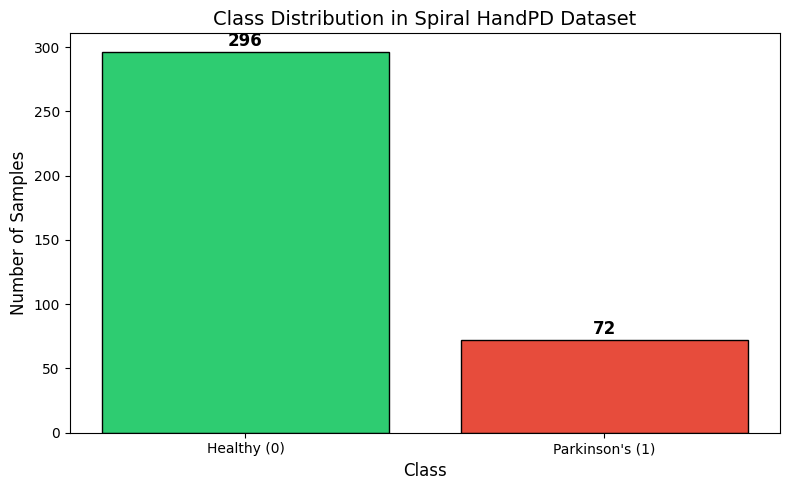

In [6]:
# Check class distribution
print("Class Distribution:")
print("="*50)
class_counts = df['class'].value_counts()
print(f"Class 0 (Healthy Controls): {class_counts.get(0, 0)}")
print(f"Class 1 (Parkinson's Disease): {class_counts.get(1, 0)}")

# Visualize class distribution
plt.figure(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Healthy (0)', "Parkinson's (1)"], class_counts.values, color=colors, edgecolor='black')
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Class Distribution in Spiral HandPD Dataset', fontsize=14)
for bar, count in zip(bars, class_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, str(count), 
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Exploratory Data Analysis (EDA)

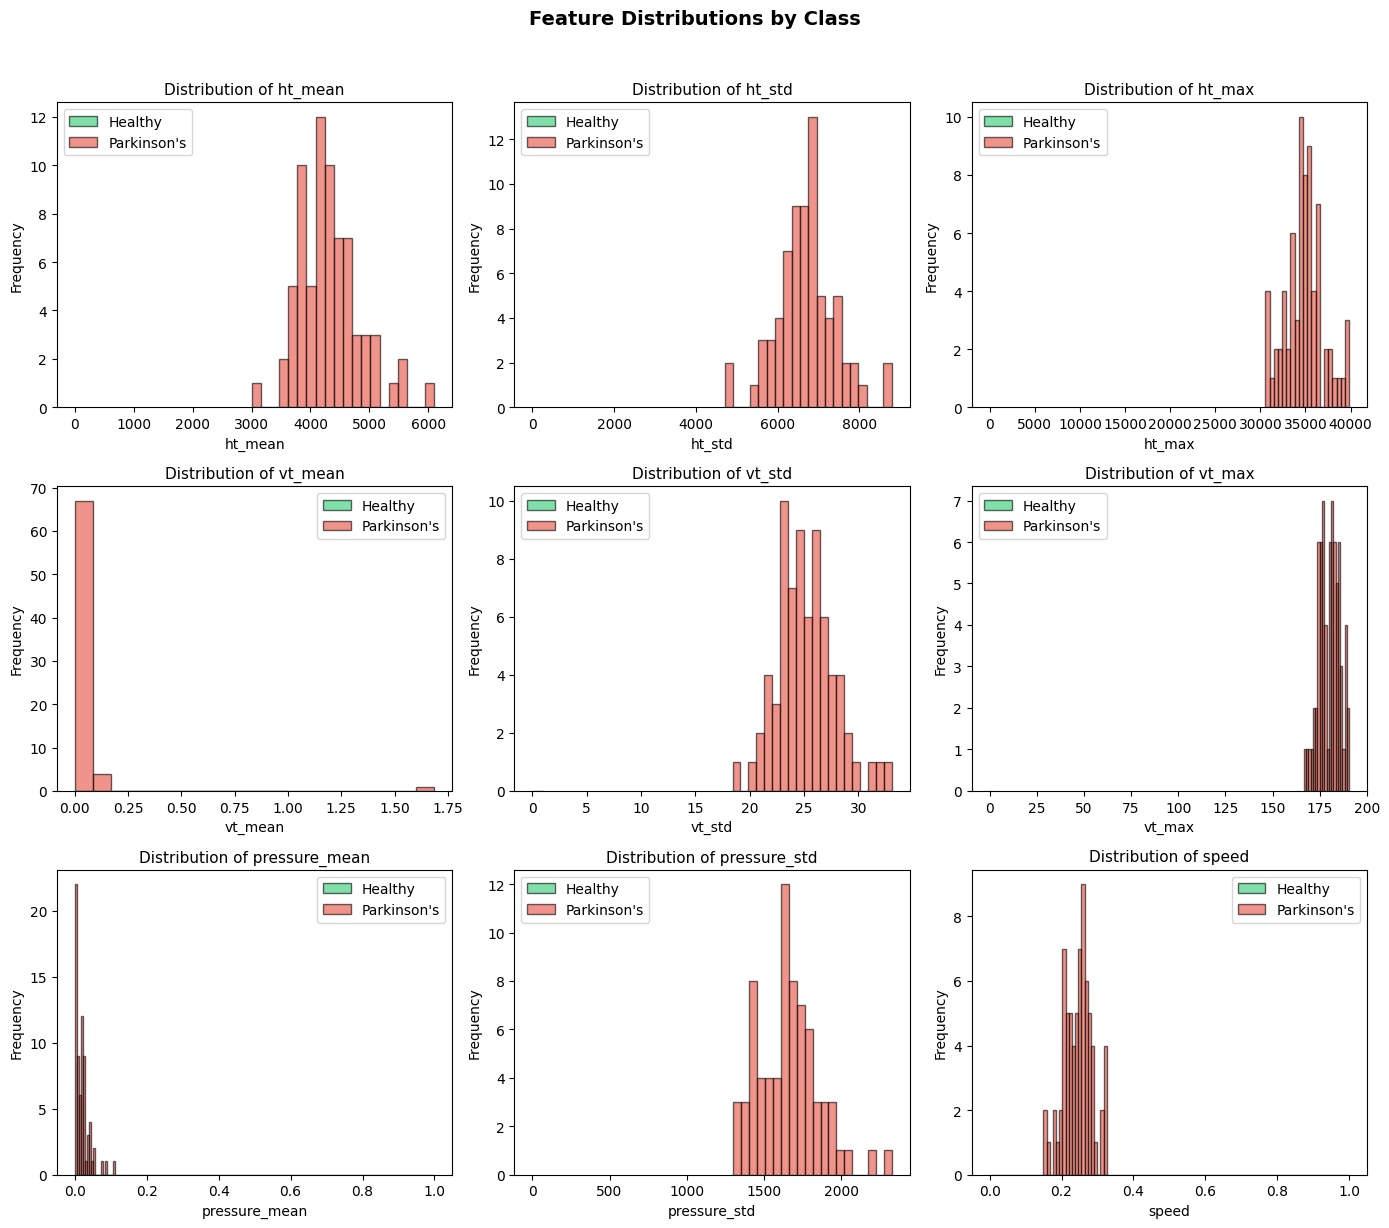

In [8]:
# Feature columns (excluding index, subject_id, and class)
feature_cols = ['ht_mean', 'ht_std', 'ht_max', 'vt_mean', 'vt_std', 'vt_max', 
                'pressure_mean', 'pressure_std', 'speed']

# Distribution of features by class
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    for class_val, color, label in [(0, '#2ecc71', 'Healthy'), (1, '#e74c3c', "Parkinson's")]:
        data = df[df['class'] == class_val][col]
        ax.hist(data, bins=20, alpha=0.6, color=color, label=label, edgecolor='black')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend()
    ax.set_title(f'Distribution of {col}', fontsize=11)

plt.suptitle('Feature Distributions by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

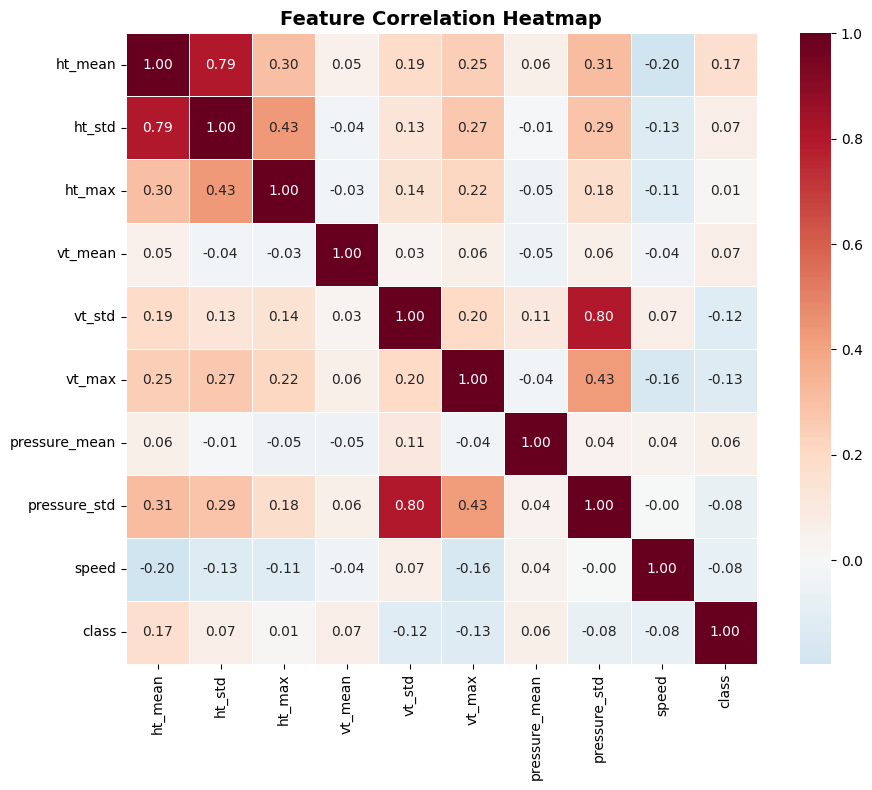

In [9]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df[feature_cols + ['class']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

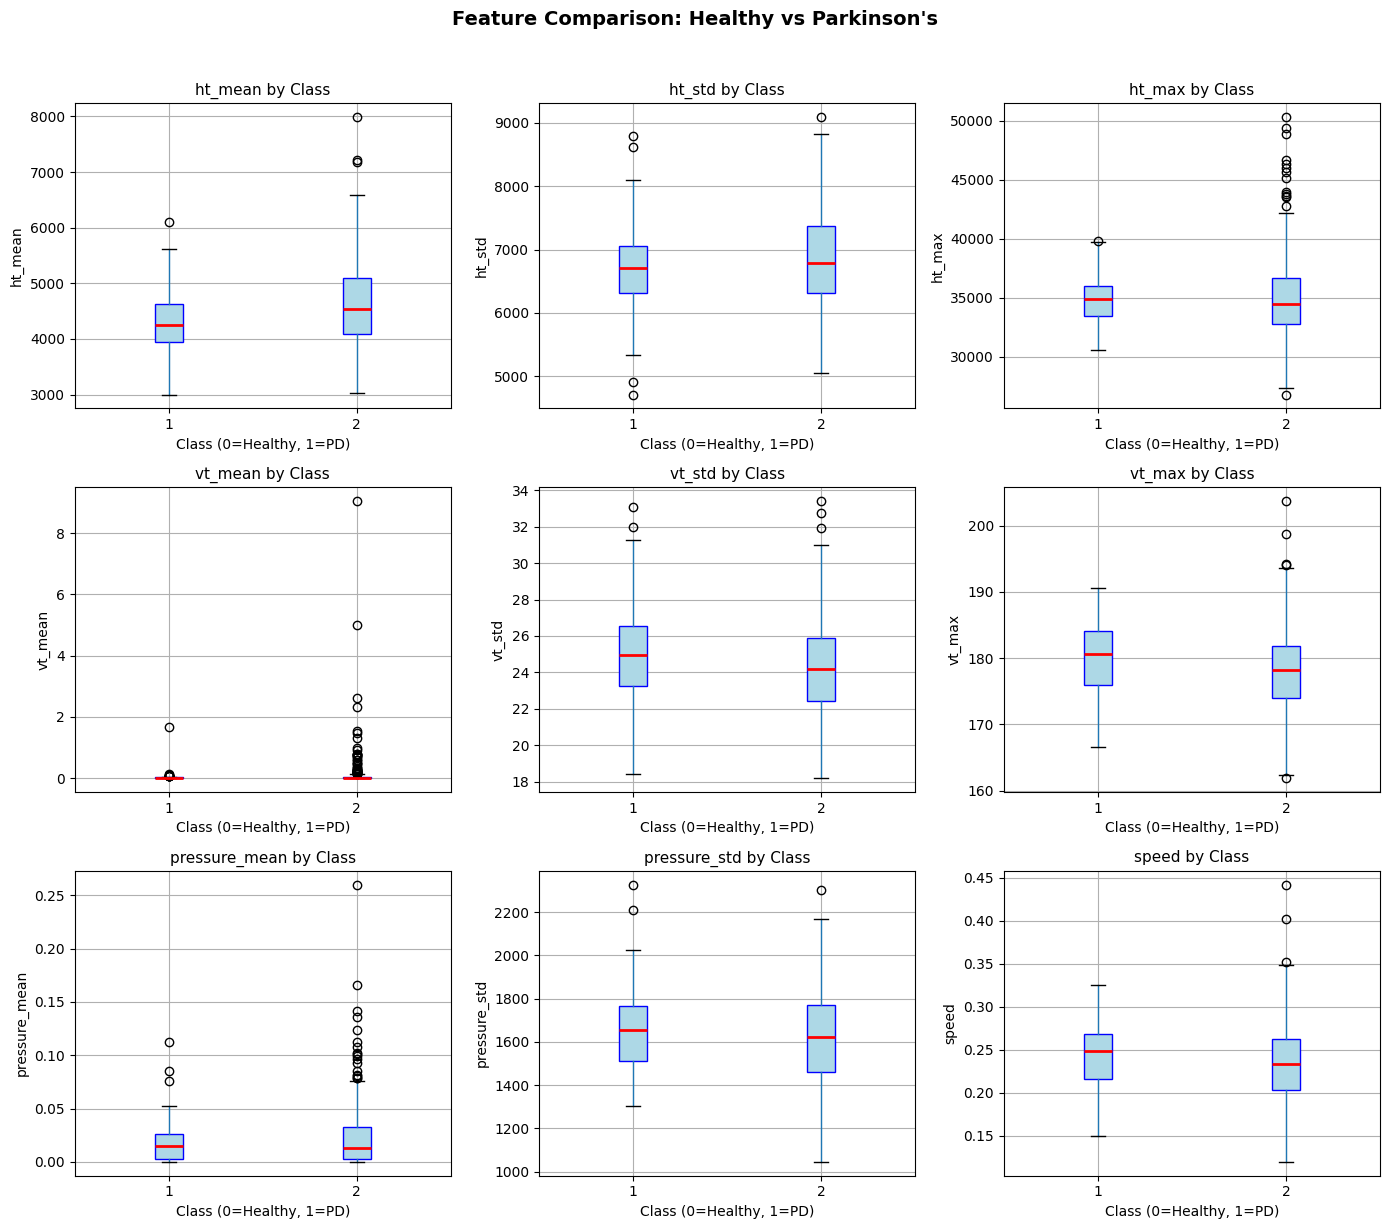

In [10]:
# Box plots to compare features between classes
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    df.boxplot(column=col, by='class', ax=ax, 
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', color='blue'),
               medianprops=dict(color='red', linewidth=2))
    ax.set_xlabel('Class (0=Healthy, 1=PD)', fontsize=10)
    ax.set_ylabel(col, fontsize=10)
    ax.set_title(f'{col} by Class', fontsize=11)

plt.suptitle('Feature Comparison: Healthy vs Parkinson\'s', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [11]:
# Prepare features (X) and target (y)
X = df[feature_cols].values
y = df['class'].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution: {np.bincount(y)}")

Features shape: (368, 9)
Target shape: (368,)

Target distribution: [  0  72 296]


In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining class distribution: {np.bincount(y_train)}")
print(f"Testing class distribution: {np.bincount(y_test)}")

Training set size: 294
Testing set size: 74

Training class distribution: [  0  58 236]
Testing class distribution: [ 0 14 60]


In [13]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"\nScaled training data mean: {X_train_scaled.mean(axis=0).round(4)}")
print(f"Scaled training data std: {X_train_scaled.std(axis=0).round(4)}")

Feature scaling completed!

Scaled training data mean: [-0.  0.  0. -0.  0.  0.  0.  0. -0.]
Scaled training data std: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 4. Model Training and Evaluation

In [14]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = []

for name, model in models.items():
    # Use scaled data for SVM, Logistic Regression, and KNN
    if name in ['Support Vector Machine', 'Logistic Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append({
        'Model': name,
        'Test Accuracy': accuracy,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std()
    })
    print(f"{name}:")
    print(f"  Test Accuracy: {accuracy:.4f}")
    print(f"  CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Logistic Regression:
  Test Accuracy: 0.7973
  CV Accuracy: 0.7994 (+/- 0.0242)
Random Forest:
  Test Accuracy: 0.7973
  CV Accuracy: 0.7993 (+/- 0.0378)
Support Vector Machine:
  Test Accuracy: 0.8108
  CV Accuracy: 0.8027 (+/- 0.0076)
K-Nearest Neighbors:
  Test Accuracy: 0.7297
  CV Accuracy: 0.7891 (+/- 0.0142)
Gradient Boosting:
  Test Accuracy: 0.8108
  CV Accuracy: 0.7788 (+/- 0.0246)


In [15]:
# Results comparison
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test Accuracy', ascending=False)
print("Model Comparison Results:")
print("="*70)
results_df

Model Comparison Results:


,Model,Test Accuracy,CV Mean,CV Std
2,Support Vector Machine,0.810811,0.802747,0.007584
4,Gradient Boosting,0.810811,0.778843,0.024596
0,Logistic Regression,0.797297,0.799416,0.024212
1,Random Forest,0.797297,0.799299,0.037836
3,K-Nearest Neighbors,0.729730,0.789071,0.014199


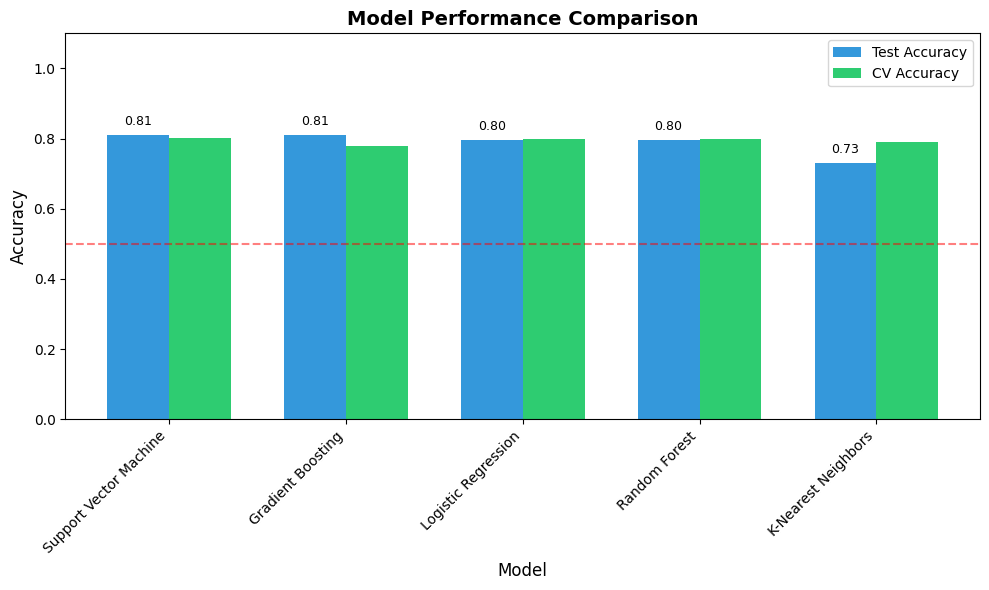

In [16]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.35

bars1 = ax.bar(x - width/2, results_df['Test Accuracy'], width, label='Test Accuracy', color='#3498db')
bars2 = ax.bar(x + width/2, results_df['CV Mean'], width, label='CV Accuracy', color='#2ecc71')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline (50%)')

# Add value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Best Model Analysis

In [17]:
# Select the best model based on test accuracy
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"Best Model: {best_model_name}")
print("="*50)

# Predict with best model
if best_model_name in ['Support Vector Machine', 'Logistic Regression', 'K-Nearest Neighbors']:
    y_pred_best = best_model.predict(X_test_scaled)
    y_prob_best = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    y_pred_best = best_model.predict(X_test)
    y_prob_best = best_model.predict_proba(X_test)[:, 1]

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, 
                            target_names=['Healthy', "Parkinson's"]))

Best Model: Support Vector Machine

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00        14
 Parkinson's       0.81      1.00      0.90        60

    accuracy                           0.81        74
   macro avg       0.41      0.50      0.45        74
weighted avg       0.66      0.81      0.73        74



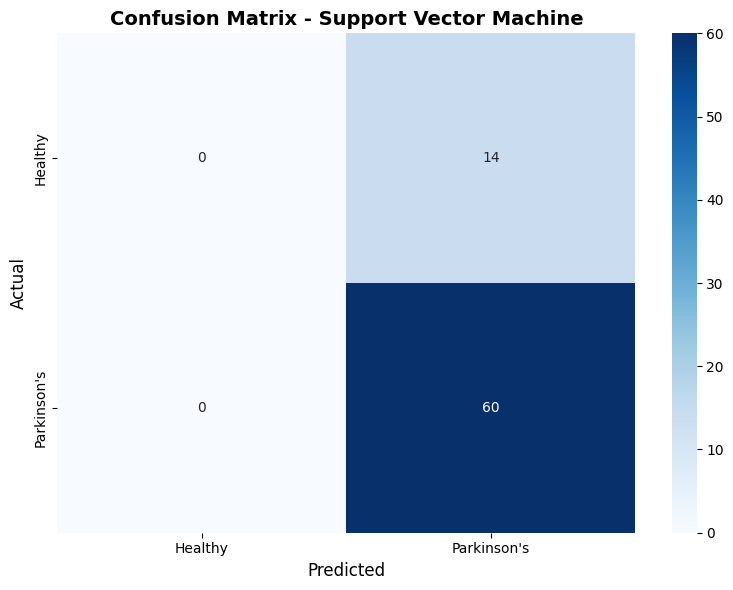


Confusion Matrix Breakdown:
True Negatives (Healthy correctly classified): 0
False Positives (Healthy misclassified as PD): 14
False Negatives (PD misclassified as Healthy): 0
True Positives (PD correctly classified): 60


In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', "Parkinson's"],
            yticklabels=['Healthy', "Parkinson's"])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate metrics from confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Healthy correctly classified): {tn}")
print(f"False Positives (Healthy misclassified as PD): {fp}")
print(f"False Negatives (PD misclassified as Healthy): {fn}")
print(f"True Positives (PD correctly classified): {tp}")

In [19]:
# # ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
# plt.fill_between(fpr, tpr, alpha=0.3, color='#3498db')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=12)
# plt.ylabel('True Positive Rate', fontsize=12)
# plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
# plt.legend(loc='lower right')
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

## 6. Feature Importance Analysis

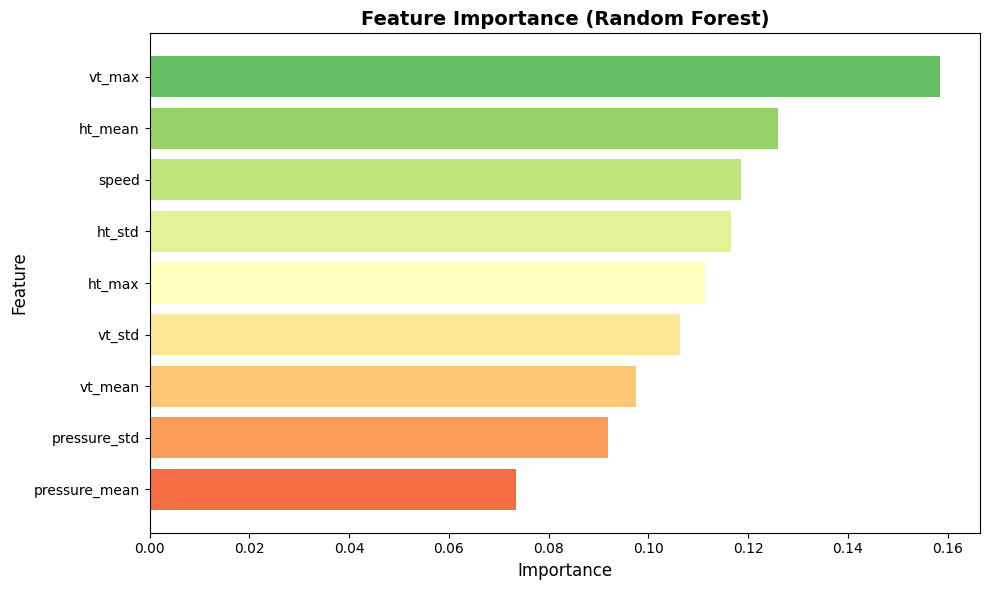


Feature Importance Ranking:
vt_max: 0.1586
ht_mean: 0.1259
speed: 0.1185
ht_std: 0.1166
ht_max: 0.1113
vt_std: 0.1063
vt_mean: 0.0975
pressure_std: 0.0919
pressure_mean: 0.0734


In [ ]:
# Feature importance (using Random Forest)
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(feature_importance)))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
print("="*50)
for idx, row in feature_importance.sort_values('Importance', ascending=False).iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

## 7. Save the Best Model

In [23]:
import joblib
import os

# Create models directory if it doesn't exist
model_dir = r'd:\Parkinson\models\saved'
os.makedirs(model_dir, exist_ok=True)

# Save the best model and scaler
model_path = os.path.join(model_dir, 'spiral_pd_classifier.joblib')
scaler_path = os.path.join(model_dir, 'spiral_scaler.joblib')

joblib.dump(best_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"Best model ({best_model_name}) saved to: {model_path}")
print(f"Scaler saved to: {scaler_path}")

Best model (Support Vector Machine) saved to: d:\Parkinson\models\saved\spiral_pd_classifier.joblib
Scaler saved to: d:\Parkinson\models\saved\spiral_scaler.joblib


## 8. Prediction Function for New Data

In [ ]:
# def predict_parkinson(features, model_path=model_path, scaler_path=scaler_path):
#     """
#     Predict Parkinson's Disease from spiral drawing features.
    
#     Parameters:
#     -----------
#     features : array-like of shape (9,) or (n_samples, 9)
#         Features: [ht_mean, ht_std, ht_max, vt_mean, vt_std, vt_max, 
#                    pressure_mean, pressure_std, speed]
    
#     Returns:
#     --------
#     prediction : str
#         'Healthy' or "Parkinson's Disease"
#     probability : float
#         Probability of Parkinson's Disease
#     """
#     model = joblib.load(model_path)
#     scaler = joblib.load(scaler_path)
    
#     features = np.array(features).reshape(1, -1)
#     features_scaled = scaler.transform(features)
    
#     prediction = model.predict(features_scaled)[0]
#     probability = model.predict_proba(features_scaled)[0][1]
    
#     result = "Parkinson's Disease" if prediction == 1 else "Healthy"
#     return result, probability

# # Example prediction with sample data
# sample_features = X_test[0]  # Using first test sample
# result, prob = predict_parkinson(sample_features)
# print(f"Sample Prediction:")
# print(f"  Result: {result}")
# print(f"  PD Probability: {prob:.2%}")
# print(f"  Actual Label: {'Parkinson\'s Disease' if y_test[0] == 1 else 'Healthy'}")

Sample Prediction:
  Result: Healthy
  PD Probability: 84.94%
  Actual Label: Healthy


## Summary

This notebook demonstrated a complete ML pipeline for Parkinson's Disease detection using spiral handwriting features:

1. **Data Loading & Exploration**: Loaded the Spiral_HandPD dataset with 9 features extracted from spiral drawings
2. **EDA**: Visualized feature distributions and correlations between healthy controls and PD patients
3. **Preprocessing**: Applied train-test split and feature scaling
4. **Model Comparison**: Evaluated 5 different classifiers (Logistic Regression, Random Forest, SVM, KNN, Gradient Boosting)
5. **Best Model Analysis**: Detailed evaluation with confusion matrix, classification report, and ROC curve
6. **Feature Importance**: Identified most discriminative features for PD detection
7. **Model Saving**: Saved the best model for future predictions

### Key Findings:
- The spiral drawing analysis can effectively distinguish between healthy individuals and PD patients
- Features related to tremor (horizontal and vertical) and pressure are particularly informative
- The model can be used for early screening of Parkinson's Disease based on handwriting analysis